# An introduction to I-24 MOTION trajectory data

## Useful links
- I24 MOTION website: https://i24motion.org/
- Request for data access: https://i24motion.org/data
- Data documentation: https://github.com/I24-MOTION/I24M_documentation
- Improvement tracker: https://github.com/I24-MOTION/I24M_improvement_tracker

## Directory structure
```
├── data_demo
│   ├── INCEPTION.22-11-22.tutorial.json
├── I24_tutorial_code
│   ├── intro_trajectory_data.ipynb
│   ├── VT_tutorial
│   │   ├── figures
│   │   ├── ASM.py
│   │   ├── macro_data_processing.py
│   │   ├── tutorial.ipynb
│   │   ├── visualization.py
│   │   ├── VT.py
```

## This tutorial will cover:
- Load JSON file using an iterative JSON parser
- Trajectory data schema
- Compute derivative quantities (e.g., speed)
- Visualize a trajectory
- Plot a time-space diagram

## Import packages

In [1]:
import ijson
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

### Read a JSON file using an iterative JSON parser

In [2]:
input_filename = "INCEPTION.22-11-22.tutorial.json"
file_path = os.path.join("../data_demo/", input_filename)

# Select one trajectory from westbound that is more than 10 sec long
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item', use_float=True)
    for record in parser:
        if record["direction"] == -1 and (record["last_timestamp"]-record["first_timestamp"]>10):
            print("Found a trajectory example")
            break

Found a trajectory example


In [3]:
for key, val in record.items():
    print(f"{key}: {val}")

_id: {'$oid': '638bb843e38fd878abf4f6fe'}
timestamp: [1669123189.1000004, 1669123189.1400003, 1669123189.1800003, 1669123189.2200003, 1669123189.2600005, 1669123189.3000004, 1669123189.3400004, 1669123189.3800004, 1669123189.4200003, 1669123189.4600003, 1669123189.5000005, 1669123189.5400004, 1669123189.5800004, 1669123189.6200004, 1669123189.6600003, 1669123189.7000003, 1669123189.7400002, 1669123189.7800004, 1669123189.8200004, 1669123189.8600004, 1669123189.9000003, 1669123189.9400003, 1669123189.9800003, 1669123190.0200005, 1669123190.0600004, 1669123190.1000004, 1669123190.1400003, 1669123190.1800003, 1669123190.2200003, 1669123190.2600005, 1669123190.3000004, 1669123190.3400004, 1669123190.3800004, 1669123190.4200003, 1669123190.4600003, 1669123190.5000005, 1669123190.5400004, 1669123190.5800004, 1669123190.6200004, 1669123190.6600003, 1669123190.7000003, 1669123190.7400002, 1669123190.7800004, 1669123190.8200004, 1669123190.8600004, 1669123190.9000003, 1669123190.9400003, 166912

### Compute the derivative quantities

In [5]:
# Compute the longitudinal speed using numerical differentiation of the x_position, i.e., v = dx/dt. np.diff() computes the first-order numerical derivative.
# Multiply by record["direction"] to indicate the direction, i.e., negative speed means traveling westbound, and positive speed means traveling eastbound.
speed = np.diff(record["x_position"])/np.diff(record["timestamp"])*record["direction"]

# Speed array is truncated by one after the numerical differentiation np.diff(). Append the first item to the array such that the speed array is the same length as the x_position array.
speed = np.append(speed[0], speed) 

# Convert unit from ft/sec to mph
speed *= 0.681818

# Print the first 10 records of speed
speed[:10]

array([37.94919921, 37.94919921, 37.97264308, 37.99610812, 38.01938789,
       38.04318107, 38.06682535, 38.09056353, 38.11441029, 38.13837878])

In [6]:
# Similarly, compute the 2nd-order numerical differentiation of the x_position to obtain acceleration. np.diff(record["x_position"], n=2) means the second order differentation of x_position.
# The unit for accel is ft/sec^2
accel = np.diff(record["x_position"], n=2)/(np.diff(record["timestamp"][:-1])**2)*record["direction"]
accel[:10]

array([0.85960954, 0.86038588, 0.86190183, 0.86409837, 0.86695798,
       0.87040104, 0.87438231, 0.87884546, 0.88375831, 0.88907717])

### Visualize a trajectory

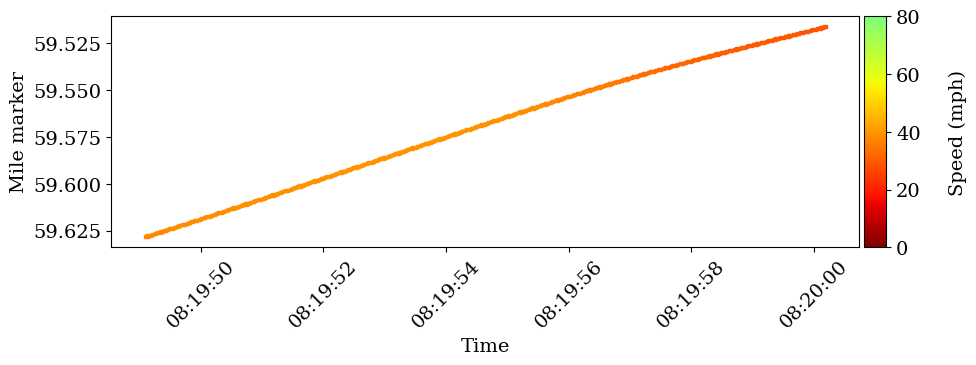

In [10]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Plot the position (y-axis) vs. time (x-axis), colored by the speed.
# Position in ft is converted to mile-marker by dividing 5280.
im = ax.scatter(record["timestamp"], np.array(record["x_position"])/5280, c= speed, cmap=green_to_red,vmin=0,vmax=80,marker = 's',s=5)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()


### Plot a time-space diagram (8:20-8:30 AM, Westbound)

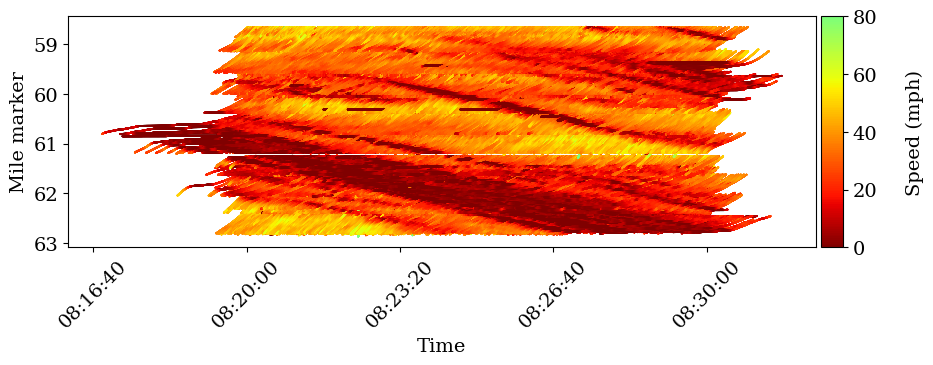

In [12]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Iterate over each trajectory record across the file, compute the speed, and plot the position and speed simultaneously
# ijson allows us to read and plot each trajectory one by one instead of loading them all into the memory
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item', use_float=True)
    for record in parser:  
        # select westbound trajectories to plot
        if record["direction"] == -1: 
            speed = np.diff(record["x_position"])/np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)   
            speed = -speed*0.681818 # convert unit, and 
            im = ax.scatter(record["timestamp"], np.array(record["x_position"])/5280, c= speed, cmap=green_to_red,vmin=0,vmax=80,s=0.1)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()

In order to plot these additional data, you will need to download the appropriate file from i24motion.org/data using your account credentials. Download it to the same directory where you found `INCEPTION.22-11-22.tutorial.json`, or else change the path location.